# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
from sklearn import linear_model as lm
import scikitplot as skplt
pd.options.mode.chained_assignment = None  # default='warn'

ModuleNotFoundError: No module named 'xgboost'

# helper functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [ ]:
def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [ ]:
def performace(model_name,data,y_val,yhat_class,k):
    import sklearn.metrics
    prec = sklearn.metrics.precision_score(y_val,yhat_class)
    recal = sklearn.metrics.recall_score(y_val,yhat_class)
    recal_k = recall_at_k(data,k)
    prec_k = precision_at_k(data,k)
    
    return pd.DataFrame({'Model Name':model_name,
                        'Precison':prec,
                        'Recall':recal,
                        'k':k,
                        'Precison at k':prec_k,
                        'Recall at k':recal_k},index=[0])

In [ ]:
def performace_cross_val(data,target,model,model_name,round_n=3,splits=4,shuffle_n=True,random=42,k=2000):
    
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits,shuffle=shuffle_n,random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target,'id'])
    precision = []
    recall = []
    prec_k = []
    rec_k = []
    for train_index, test_index in skf.split(X,y):
        #train the model 
        model.fit(X.iloc[train_index],y.iloc[train_index])

        #predict the classification 
        yhat_class = model.predict( X.iloc[test_index] )

        #predict the probabilit
        yhat_proba = model.predict_proba(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index],yhat_class)
        rec = sklearn.metrics.recall_score(y.iloc[test_index],yhat_class)
        precision.append(prec)
        recall.append(rec)

        # sort the test dataframe by the probabiliti score of the model
        aux = X.iloc[test_index]
        aux[target] = y.iloc[test_index]
        aux['score'] = yhat_proba[:,1].tolist()

        # sorte by score
        aux = aux.sort_values('score',ascending=False)

        # precision and recall at k
        prec_k.append(precision_at_k(aux,k))
        rec_k.append(recall_at_k(aux,k))

    # return a dataset with the metrics    
    return pd.DataFrame({'Model name': model_name + " Cross_Val",
                                'PRECISION CROSS_VAL': np.round( np.mean( precision ), round_n ),
                                'PRECISON STD': np.round( np.std( precision ), round_n ),
                                'RECALL CROSS_VAL': np.round( np.mean( recall ), round_n ),
                                'RECALL STD': np.round( np.std( recall ), round_n ),
                                'K': k,
                                'PRECISION AT K CROSS_VAL': np.round( np.mean( prec_k ), round_n ),
                                'PRECISION AT K STD': np.round( np.std( prec_k ), round_n ),
                                'RECALL AT K CROSS_VAL': np.round( np.mean( rec_k), round_n ),
                                'RECALL AT K STD': np.round( np.std( rec_k )) },index=[0]) 

# Load data

In [ ]:
df6 = pd.read_csv('data/df5.csv')

In [ ]:
df6.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response
0,1,0.369231,28.0,26.0,0,0.716263,3,1,1
1,2,0.861538,3.0,26.0,0,0.598616,2,0,0
2,3,0.415385,28.0,26.0,0,0.058824,3,1,1
3,4,0.015385,11.0,152.0,1,0.667820,1,0,0
4,5,0.138462,41.0,152.0,1,0.100346,1,0,0


In [ ]:
df6.dtypes

id                        int64
age                     float64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
vintage                 float64
vehicle_age               int64
vehicle_damage            int64
response                  int64
dtype: object

## Slipt train test

In [ ]:
train, val = train_test_split(df6,test_size=0.3,stratify=df6['response'],random_state=42)

# train dataframes
X_train = train.copy()
y_train = X_train['response']
X_train.drop(columns = ['response','id'],inplace=True)
# validation dataframes
x_val = val.copy()
y_val = val['response']
x_val.drop(columns = ['response','id'],inplace=True)

# Machine learning

## KNN

In [ ]:
#model
knn_model = KNeighborsClassifier(n_neighbors=5)

# model training
knn_model.fit(X_train,y_train)

In [ ]:
#model prediction proba - poder de generalizção
yhat_knn_proba = knn_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_knn_class = knn_model.predict( x_val )

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


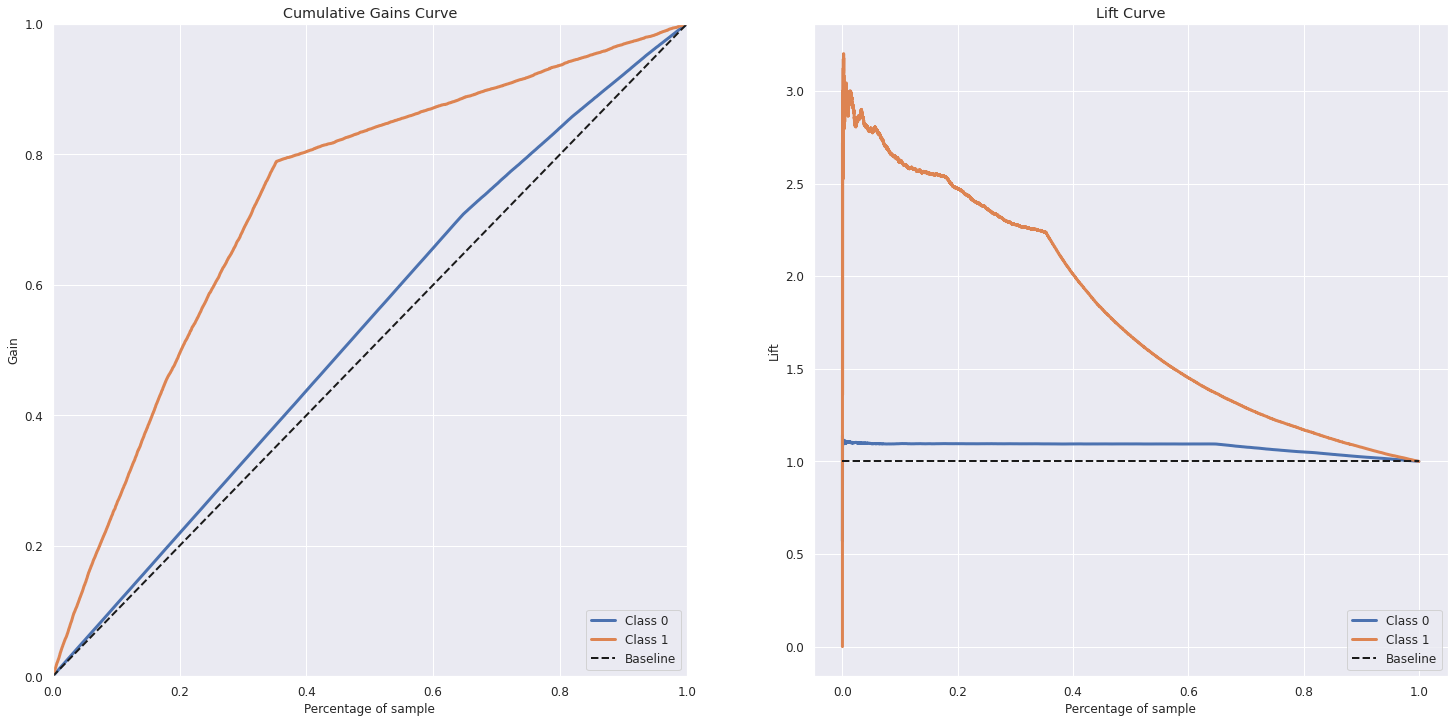

In [ ]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_knn_proba,ax=ax[1]);

## Linear model

In [ ]:
lm_model = lm.LogisticRegression(random_state=42,n_jobs=-1)
lm_model.fit(X_train,y_train)

In [ ]:
#model prediction proba - poder de generalizção
yhat_lm_proba = lm_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_lm_class = lm_model.predict( x_val )

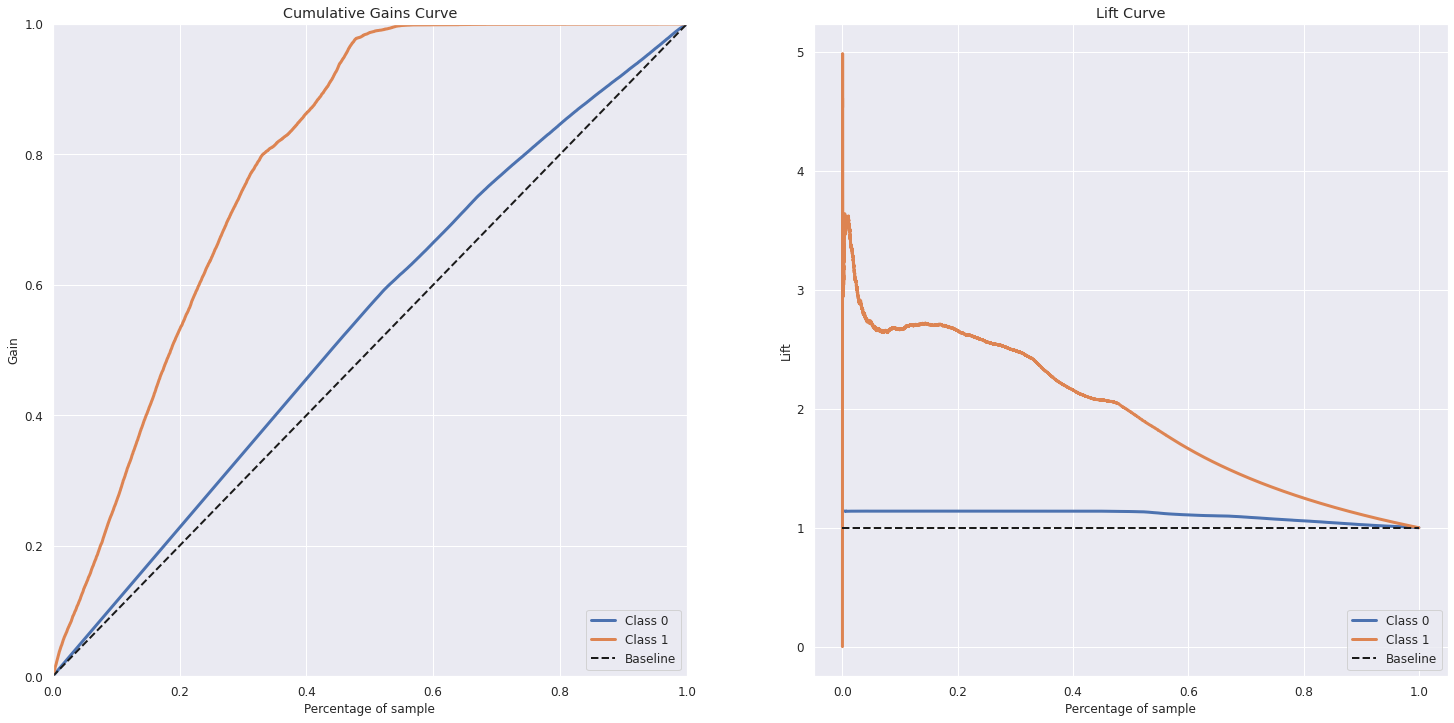

In [ ]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_lm_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_lm_proba,ax=ax[1]);

## Random forrest classifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
#model prediction proba - poder de generalizção
yhat_rf_proba = rf_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_rf_class = rf_model.predict( x_val )

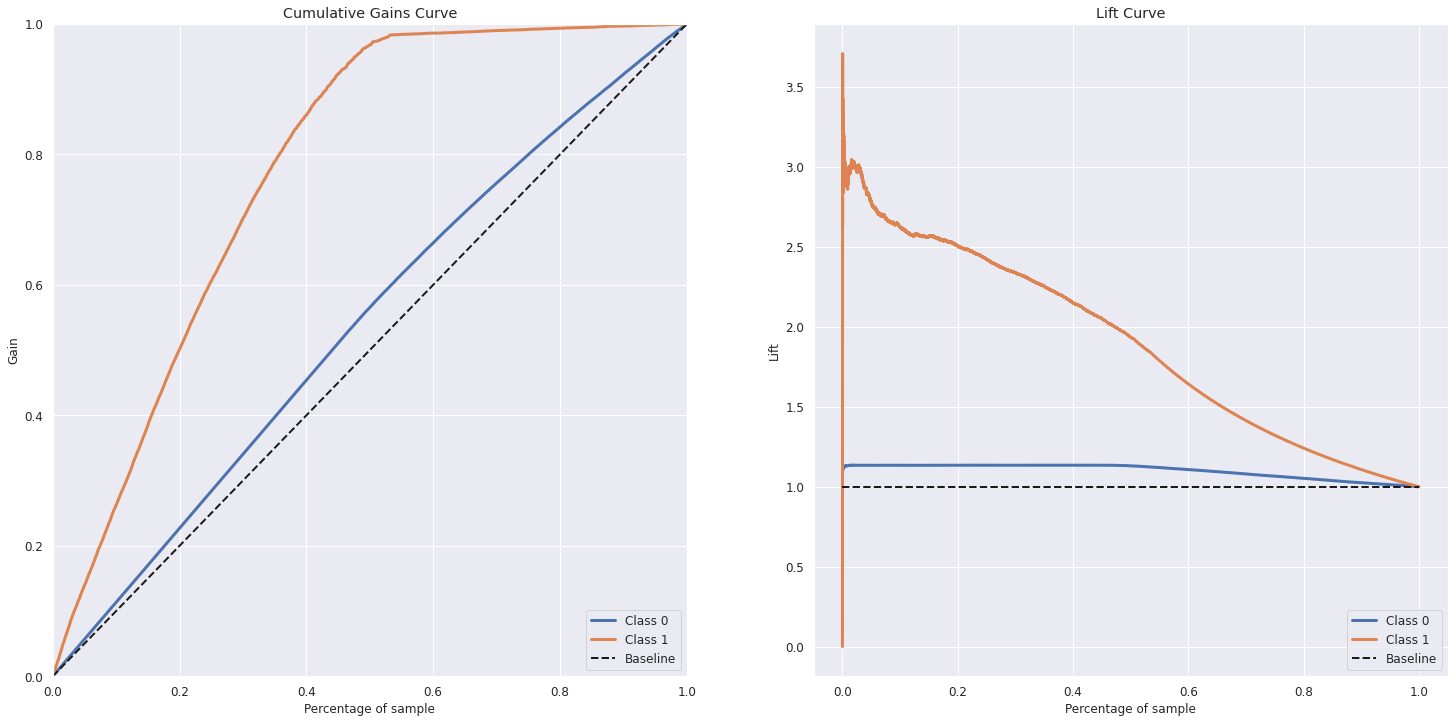

In [ ]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_rf_proba,ax=ax[1]);

## Extratree classifier

In [ ]:
et_model = ExtraTreesClassifier(n_estimators=1000,random_state=42,n_jobs=-1,max_depth=10)
et_model.fit(X_train,y_train)

ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [ ]:
#model prediction proba - poder de generalizção
yhat_et_proba = et_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_et_class = et_model.predict( x_val )

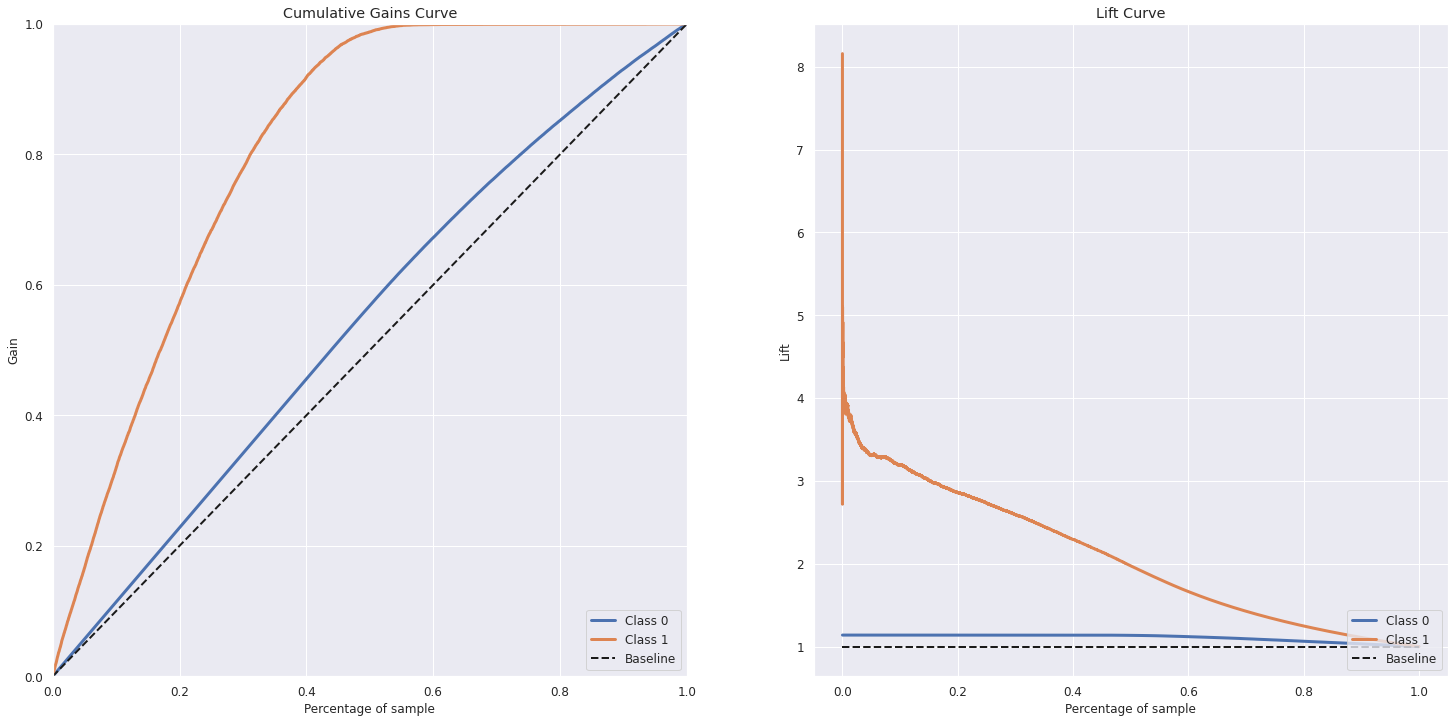

In [ ]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_et_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_et_proba,ax=ax[1]);

## XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(objective='reg:squarederror',
                             n_estimators=1000,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(X_train,y_train)

In [ ]:
#model prediction proba - poder de generalizção
yhat_xgb_proba = xgb_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_xgb_class = xgb_model.predict( x_val )

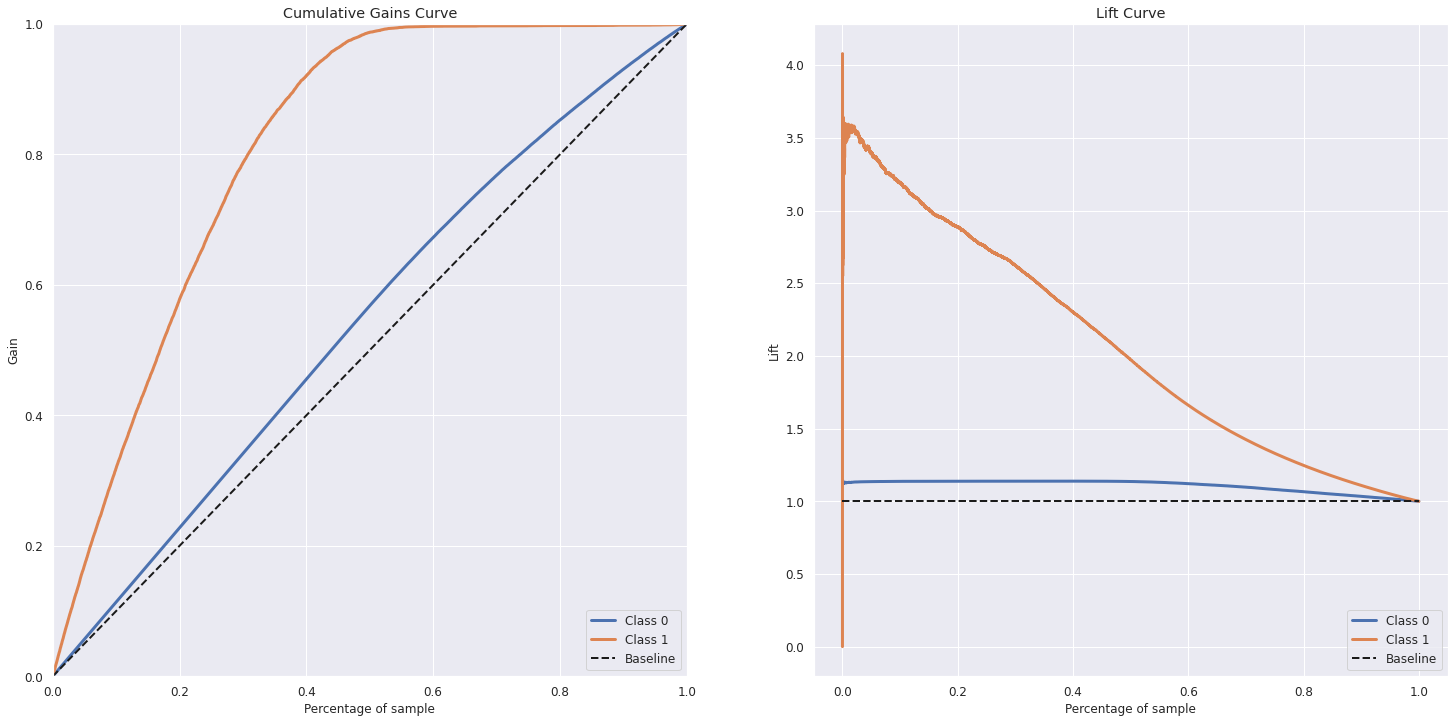

In [ ]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_xgb_proba,ax=ax[1]);

# Model performace 

In [ ]:
clients = 20000

## KNN

In [ ]:
knn_df = val.copy()

In [ ]:
knn_df['score_knn'] = yhat_knn_proba[:,1].tolist()
# sorte by score
knn_df = knn_df.sort_values('score_knn',ascending=False)

In [ ]:
knn_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_knn
194783,194784,0.153846,43.0,155.0,0,0.778547,2,1,0,1.0
235906,235907,0.153846,33.0,124.0,0,0.058824,1,1,0,1.0
66091,66092,0.369231,28.0,26.0,0,0.944637,3,1,0,1.0
364418,364419,0.338462,30.0,124.0,0,0.826990,2,1,0,1.0
378903,378904,0.153846,3.0,124.0,0,0.190311,1,1,0,1.0


In [ ]:
knn_performace = performace("KNN",knn_df,y_val,yhat_knn_class,clients)

In [ ]:
knn_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,KNN,0.339061,0.178834,20000,0.311384,0.444444


## Linear model

In [ ]:
lm_df = val.copy()

In [ ]:
lm_df['score_lm'] = yhat_lm_proba[:,1].tolist()
# sorte by score
lm_df = lm_df.sort_values('score_lm',ascending=False)

In [ ]:
lm_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_lm
205844,205845,0.169231,1.0,26.0,0,0.380623,3,1,0,0.536247
375383,375384,0.153846,9.0,31.0,0,0.782007,3,1,0,0.535942
334418,334419,0.184615,28.0,26.0,0,0.141869,3,1,0,0.529711
330638,330639,0.184615,28.0,26.0,0,0.432526,3,1,1,0.528954
91143,91144,0.184615,28.0,26.0,0,0.979239,3,1,0,0.527531


In [ ]:
lm_performace = performace("linear model",lm_df,y_val,yhat_lm_class,clients)

In [ ]:
lm_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,linear model,0.457627,0.001927,20000,0.330933,0.472347


## Randon forrest

In [ ]:
rf_df = val.copy()

In [ ]:
rf_df['score_rf'] = yhat_rf_proba[:,1].tolist()
# sorte by score
rf_df = rf_df.sort_values('score_rf',ascending=False)

In [ ]:
rf_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_rf
106975,106976,0.153846,28.0,26.0,0,0.162630,1,1,0,0.996667
223683,223684,0.369231,28.0,26.0,0,0.851211,2,1,0,0.993988
72981,72982,0.384615,28.0,26.0,0,0.653979,2,1,0,0.991248
184469,184470,0.384615,28.0,26.0,0,0.653979,2,1,0,0.991248
336024,336025,0.384615,28.0,26.0,0,0.653979,2,1,1,0.991248


In [ ]:
rf_performace = performace("Random forest",rf_df,y_val,yhat_rf_class,clients)

In [ ]:
rf_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,Random forest,0.326515,0.208449,20000,0.311134,0.444088


## Extra trees

In [ ]:
et_df = val.copy()

In [ ]:
et_df['score_et'] = yhat_et_proba[:,1].tolist()
# sorte by score
et_df = et_df.sort_values('score_et',ascending=False)

In [ ]:
et_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_et
79757,79758,0.461538,46.0,26.0,0,0.986159,1,1,1,0.474894
180725,180726,0.600000,28.0,26.0,0,0.837370,1,1,0,0.472824
282873,282874,0.538462,41.0,26.0,0,0.702422,1,1,0,0.467928
292587,292588,0.507692,28.0,26.0,0,0.719723,1,1,1,0.461108
198227,198228,0.769231,28.0,26.0,0,0.387543,1,1,0,0.458349


In [ ]:
et_performace = performace("Extra trees",et_df,y_val,yhat_et_class,clients)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
et_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,Extra trees,0.0,0.0,20000,0.359082,0.512524


## XGboost

In [ ]:
xgb_df = val.copy()

In [ ]:
xgb_df['score_xgb'] = yhat_xgb_proba[:,1].tolist()
# sorte by score
xgb_df = xgb_df.sort_values('score_xgb',ascending=False)

In [ ]:
xgb_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_xgb
308033,308034,0.446154,8.0,3.0,0,0.996540,2,1,0,0.839975
269431,269432,0.153846,3.0,163.0,0,0.975779,2,1,0,0.775396
359029,359030,0.584615,28.0,3.0,0,0.619377,3,1,0,0.772347
324645,324646,0.092308,7.0,124.0,0,0.003460,1,1,0,0.759864
180725,180726,0.600000,28.0,26.0,0,0.837370,1,1,0,0.742564


In [ ]:
xgb_performace = performace("XGBoost",xgb_df,y_val,yhat_xgb_class,clients)

In [ ]:
xgb_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,XGBoost,0.432353,0.020981,20000,0.361082,0.515379


# Model comparrison

In [ ]:
model_comp = pd.concat([knn_performace,lm_performace,rf_performace,et_performace,xgb_performace])

In [ ]:
model_comp.sort_values(by='Recall at k',ascending=False)

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,XGBoost,0.432353,0.020981,20000,0.361082,0.515379
0,Extra trees,0.000000,0.000000,20000,0.359082,0.512524
0,linear model,0.457627,0.001927,20000,0.330933,0.472347
0,KNN,0.339061,0.178834,20000,0.311384,0.444444
0,Random forest,0.326515,0.208449,20000,0.311134,0.444088


# Croos validation

In [ ]:
models = {
    'KNN': knn_model,
    'Linear model': lm_model,
    'Random forrest': rf_model,
    'Extra trees': et_model,
    'XGBoost':xgb_model
}

In [ ]:
models_comparison = pd.DataFrame()

In [ ]:
for c, v in models.items():
    aux = performace_cross_val(df6,'response',v,c,k=20000)
    models_comparison = pd.concat([models_comparison,aux])

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

KeyboardInterrupt: 

In [ ]:
models_comparison.sort_values(by='RECALL AT K CROSS_VAL',ascending=False)

,Model name,PRECISION CROSS_VAL,PRECISON STD,RECALL CROSS_VAL,RECALL STD,K,PRECISION AT K CROSS_VAL,PRECISION AT K STD,RECALL AT K CROSS_VAL,RECALL AT K STD
0,KNN Cross_Val,0.340,0.005,0.183,0.001,20000,0.301,0.002,0.515,0.0
0,Linear model Cross_Val,0.384,0.082,0.001,0.001,20000,0.319,0.003,0.546,0.0
0,Random forrest Cross_Val,0.324,0.001,0.205,0.001,20000,0.305,0.003,0.522,0.0
0,Extra trees Cross_Val,0.200,0.212,0.000,0.000,20000,0.346,0.004,0.593,0.0
0,XGBoost Cross_Val,0.455,0.014,0.021,0.003,20000,0.349,0.004,0.598,0.0


In [ ]:
models_comparison.to_csv('data/models_comparison.csv',index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3161d838-98a4-47ed-ae81-127ad2068af4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>